In [55]:
import pandas as pd
df = pd.read_csv('retail_store_inventory.csv')

df.dtypes

Date                   object
Store ID               object
Product ID             object
Category               object
Region                 object
Inventory Level         int64
Units Sold              int64
Units Ordered           int64
Demand Forecast       float64
Price                 float64
Discount                int64
Weather Condition      object
Holiday/Promotion       int64
Competitor Pricing    float64
Seasonality            object
dtype: object

In [56]:
#drop outliers (z-score <=3)
from scipy.stats import zscore

df['z_score'] = zscore(df['Units Sold'])
df = df[df['z_score'].abs() < 3]
df = df.drop(columns=['z_score'])

df = df.drop(columns=['Demand Forecast','Units Ordered'])

In [57]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

In [58]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df[['Units Sold', 'Price', 'Competitor Pricing', 'Inventory Level']] = scaler.fit_transform(
    df[['Units Sold', 'Price', 'Competitor Pricing', 'Inventory Level']]
)

In [59]:
from sklearn.preprocessing import LabelEncoder

Discount_Sequence = ['0', '5', '10', '15', '20']  # Custom order

label_encoder = LabelEncoder()
label_encoder.fit(Discount_Sequence)  # Fit with the custom order
df['Discount'] = label_encoder.transform(df['Discount'])

df = pd.get_dummies(df, columns=['Weather Condition', 'Holiday/Promotion','Seasonality','Region','Store ID','Product ID','Category'], drop_first=True)


In [60]:
boolean_columns = [
    'Weather Condition_Rainy', 'Weather Condition_Snowy', 'Weather Condition_Sunny',
    'Holiday/Promotion_1', 'Seasonality_Spring', 'Seasonality_Summer', 'Seasonality_Winter',
    'Region_North', 'Region_South', 'Region_West',
    'Store ID_S002', 'Store ID_S003', 'Store ID_S004', 'Store ID_S005',
    'Product ID_P0002', 'Product ID_P0003', 'Product ID_P0004', 'Product ID_P0005',
    'Product ID_P0006', 'Product ID_P0007', 'Product ID_P0008', 'Product ID_P0009',
    'Product ID_P0010', 'Product ID_P0011', 'Product ID_P0012', 'Product ID_P0013',
    'Product ID_P0014', 'Product ID_P0015', 'Product ID_P0016', 'Product ID_P0017',
    'Product ID_P0018', 'Product ID_P0019', 'Product ID_P0020',
    'Category_Electronics', 'Category_Furniture', 'Category_Groceries', 'Category_Toys'
]

df[boolean_columns] = df[boolean_columns].astype(int)
df = df.drop(columns=['Date'])


/Users/xiaoming/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - loss: 0.0569 - val_loss: 0.0545
Epoch 2/100
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - loss: 0.0541 - val_loss: 0.0539
Epoch 3/100
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - loss: 0.0542 - val_loss: 0.0539
Epoch 4/100
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - loss: 0.0535 - val_loss: 0.0539
Epoch 5/100
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - loss: 0.0542 - val_loss: 0.0541
Epoch 6/100
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - loss: 0.0544 - val_loss: 0.0539
Epoch 7/100
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - loss: 0.0543 - val_loss: 0.0540
Epoch 8/100
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 0.0536 - val_loss: 0.0542
Epoch 9/100
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 0.0537 - val_loss: 0.0539
Epoch 10/100
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 0.0536 - val_loss: 0.0542
Epoch 11/100
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 0.0530 - val_loss: 0.05

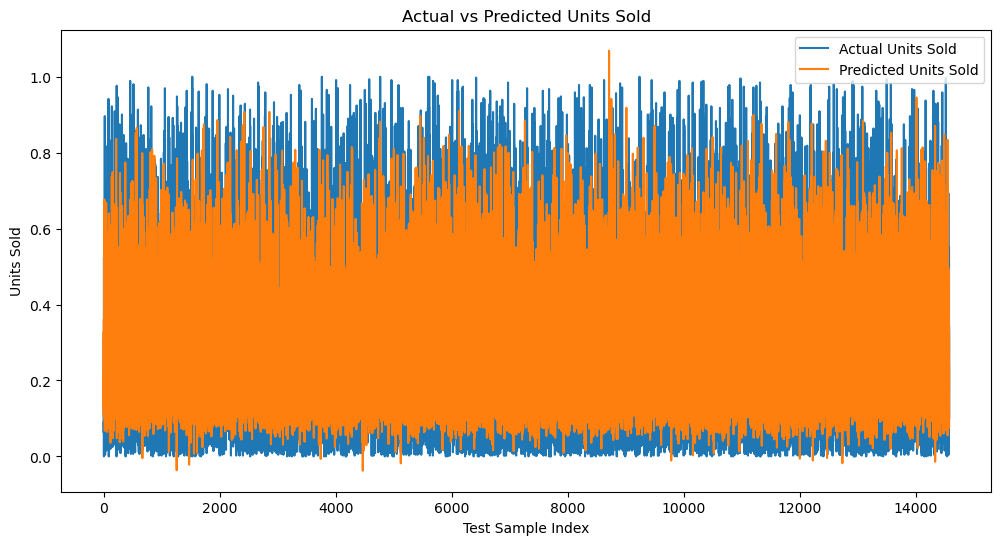

In [61]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assuming df is the dataframe where 'Units Sold' is the target variable
X = df.drop(columns=['Units Sold'])  # Drop the target column from the feature set
y = df['Units Sold']  # Set the target column as y

window_size = 14  # Use the last 14 days for prediction
X_seq, y_seq = [], []

# Create sliding windows for past data
for i in range(window_size, len(X)):
    X_seq.append(X.iloc[i - window_size:i].values)  # Last 14 days as input for each sample
    y_seq.append(y.iloc[i])  # Target variable (Units Sold) for the next day

# Convert to numpy arrays
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Step 4: Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Reshape the data for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Step 5: Build the LSTM Model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer for predicting 'Units Sold' for the next day
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Step 6: Build the model
model = build_lstm_model((X_train.shape[1], X_train.shape[2]))  # Define input shape based on the number of timesteps and features

# Step 7: Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Step 8: Evaluate the model
predictions = model.predict(X_test)

# Inverse transform predictions and actual values back to the original scale (Units Sold)
predictions = predictions.flatten()  # Flatten to 1D array for easier comparison
y_test_original = y_test

# Step 9: Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test_original, predictions))
print(f'RMSE: {rmse:.2f}')

# Step 10: Plot Actual vs Predicted Units Sold
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual Units Sold')
plt.plot(predictions, label='Predicted Units Sold')
plt.title('Actual vs Predicted Units Sold')
plt.xlabel('Test Sample Index')
plt.ylabel('Units Sold')
plt.legend()
plt.show()

In [6]:
%pip install scikeras
%pip install tensorflow
%pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Reloading Tuner from my_dir/lstm_tuning/tuner0.json
Epoch 1/50


/Users/xiaoming/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/xiaoming/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1828/1828 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 245.6311 - val_loss: 112.8570
Epoch 2/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 234.8073 - val_loss: 160.4435
Epoch 3/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - loss: 231.1816 - val_loss: 118.6106
Epoch 4/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 230.6786 - val_loss: 90.4056
Epoch 5/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 224.7672 - val_loss: 135.5433
Epoch 6/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 230.9792 - val_loss: 99.9568
Epoch 7/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 224.3629 - val_loss: 131.2687
Epoch 8/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 227.5466 - val_loss: 116.0032
Epoch 9/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 231.8823 - val_loss: 133.3228
Epoch 10/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 228.2389 - val_loss: 91.8712
Epoch 11/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 219.0047 - val_loss: 101

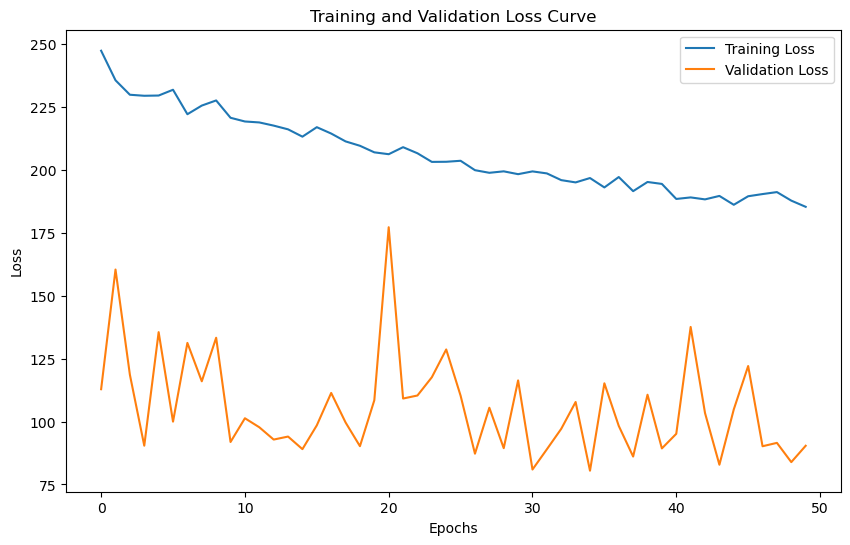

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the dataset
df = pd.read_csv('retail_store_inventory.csv')

# Preprocessing: Convert Date column to datetime and fill missing values
df['Date'] = pd.to_datetime(df['Date'])
df = df.fillna(0)  # Fill missing values (customize as needed)

# Convert categorical columns to numeric
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'Store ID', 'Product ID', 'Region', 'Weather Condition', 'Seasonality']
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

# Define features (X) and target (y)
X = df.drop(columns=['Units Sold', 'Date'])  # Dropping target column 'Units Sold' and 'Date'
y = df['Units Sold']

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape the data to fit LSTM input requirements (samples, timesteps, features)
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the function to create the LSTM model for tuning
def create_lstm_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                                   return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(1))  # Output layer with 1 unit for regression task
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

# Initialize the Keras Tuner with RandomSearch
tuner = kt.RandomSearch(
    create_lstm_model,
    objective='val_loss',  # Minimize validation loss
    max_trials=5,  # Number of random configurations to try
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_tuning'
)

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Fit the best model to the data and capture history
history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)

# Evaluate using RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# **Plot the Loss Curve (Training Loss vs Validation Loss)**
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
import pickle

# Save the model using pickle
with open('best_lstm_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Model saved as 'best_lstm_model.pkl'")

Model saved as 'best_lstm_model.pkl'
